In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# SƠ LƯỢC DỮ LIỆU

In [2]:
local_path = "data\MWG-12423.csv"
foreign_path = "data\MWG-ndtnn-12423.csv"

In [3]:
header_local = ['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return','daily_return_pct', 'KL', 'GT']
column_range = list(range(9))
df_local = pd.read_csv(local_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for local invest
df_local.columns = header_local
print(f"Dữ liệu bao gồm {df_local.shape[0]} dòng và {df_local.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_local.head()

Dữ liệu bao gồm 251 dòng và 9 cột:
Mẫu bảng dữ liệu :



,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640"
1,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992"
2,07/04/2023,"2,661,000","105,114","57,072","39,000",-100,-0.26,"2,032,200","78,830"
3,06/04/2023,"2,531,100","101,826","57,218","39,100",-650,-1.64,"1,971,300","78,034"
4,05/04/2023,"1,735,900","68,838","58,169","39,750",-50,-0.13,"1,735,900","68,838"


In [4]:
header_foreign = ['date', 'room', 'remain_room_stk','remain_room_pct','kl_buy','kl_buy_pct', 'gt_buy','gt_buy_pct','kl_sell','kl_sell_pct', 'gt_sell','gt_sell_pct','KL_foreign_diff','GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']
column_range = list(range(18))
df_foreign = pd.read_csv(foreign_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for foreign invest
df_foreign.columns = header_foreign
print(f"Dữ liệu bao gồm {df_foreign.shape[0]} dòng và {df_foreign.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_foreign.head()

Dữ liệu bao gồm 251 dòng và 18 cột:
Mẫu bảng dữ liệu :



,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,11/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"2,897,200",100,"127,042,220,000",100
1,10/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000",112.89
2,07/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"628,800",100,"26,283,840,000",100
3,06/04/2023,"717,300,847",-,NaN,100,0.01,"4,000,000",0.01,-,NaN,-,NaN,100,"4,000,000","559,800",100,"23,791,500,000",100
4,05/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN


In [5]:
foreign_main_cols = header_foreign[3:]
print(foreign_main_cols)

['remain_room_pct', 'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct', 'kl_sell', 'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']


# PREPROCESSING

Merge 2 dataframes

In [6]:
df = pd.merge(df_local, df_foreign, on="date")
df.drop(columns=['room'], axis=1, inplace =True) #We don't need that
df.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,remain_room_stk,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640",-,...,-,NaN,-,NaN,-,-,"2,897,200",100,"127,042,220,000",100
1,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992",-,...,-,NaN,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000",112.89
2,07/04/2023,"2,661,000","105,114","57,072","39,000",-100,-0.26,"2,032,200","78,830",-,...,-,NaN,-,NaN,-,-,"628,800",100,"26,283,840,000",100
3,06/04/2023,"2,531,100","101,826","57,218","39,100",-650,-1.64,"1,971,300","78,034",-,...,-,NaN,-,NaN,100,"4,000,000","559,800",100,"23,791,500,000",100
4,05/04/2023,"1,735,900","68,838","58,169","39,750",-50,-0.13,"1,735,900","68,838",-,...,-,NaN,-,NaN,-,-,-,NaN,-,NaN


In [7]:
df.columns

Index(['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return',
       'daily_return_pct', 'KL', 'GT', 'remain_room_stk', 'remain_room_pct',
       'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct', 'kl_sell',
       'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff',
       'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct'],
      dtype='object')

Feature engineer with date time

In [8]:
# Convert the date column to a pandas datetime object
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.sort_values(by='date', ascending=True, ignore_index = True)

In [9]:
df.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,remain_room_stk,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,2022-04-12,"4,276,300","656,745","111,780","152,700","2,700",1.80,"2,644,500","394,841",-,...,-,NaN,-,NaN,-,-,"1,631,800",100,"261,903,900,000",100
1,2022-04-13,"12,958,400","2,045,754","114,342","156,200","3,500",2.29,"3,406,000","520,444",10,...,-,NaN,-,NaN,"15,100","2,280,100,000","9,552,400",100,"1,525,309,700,000",100
2,2022-04-14,"2,992,800","477,771","116,758","159,500","3,300",2.11,"2,925,900","467,335",10,...,-,NaN,-,NaN,-,-,-,NaN,-,NaN
3,2022-04-15,"2,959,800","480,101","117,270","160,200",700,0.44,"2,339,800","374,329",-,...,-,NaN,-,NaN,-,-,"620,000",100,"105,772,000,000",100
4,2022-04-18,"2,933,800","474,702","117,270","160,200",NaN,NaN,"2,616,900","420,385",-,...,"3,800",0.15,"612,110,000",0.15,"-3,800","-612,110,000","316,900",100,"54,316,660,000",100


Convert data types and fill NaN

In [10]:
def convert_type(dataframe):
    dataframe = dataframe.fillna(0)
    for col in dataframe.columns:
        if col == 'date':
            continue
        else:
            dataframe[col] = dataframe[col].apply(
                lambda x: float(str(x).replace(',', '').replace('-', '0'))
                if isinstance(x, str) and x.strip() != ''
                else (np.nan if isinstance(x, str) and x.strip() == '' else x)
            )
    return dataframe
df = convert_type(df)

MA price

In [11]:
ma_day = [10, 20]
for ma in ma_day:
    column_name = f"MA{ma}"
    df[column_name] = df['close_price'].rolling(ma).mean()

In [12]:
df = df.dropna()
df.tail()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,remain_room_stk,...,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct,MA10,MA20
246,2023-04-05,1735900.0,68838.0,58169.0,39750.0,50.0,-0.13,1735900.0,68838.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.00,38735.0,38922.5
247,2023-04-06,2531100.0,101826.0,57218.0,39100.0,650.0,-1.64,1971300.0,78034.0,0.0,...,0.0,0.0,100.0,4000000.0,559800.0,100.00,2.379150e+10,100.00,38865.0,38877.5
248,2023-04-07,2661000.0,105114.0,57072.0,39000.0,100.0,-0.26,2032200.0,78830.0,0.0,...,0.0,0.0,0.0,0.0,628800.0,100.00,2.628384e+10,100.00,38970.0,38840.0
249,2023-04-10,10616296.0,436606.0,59998.0,41000.0,2000.0,5.13,5829400.0,236992.0,0.0,...,0.0,0.0,0.0,0.0,5403900.0,112.89,2.253426e+11,112.89,39260.0,38920.0
250,2023-04-11,5749500.0,242682.0,59559.0,40700.0,300.0,-0.73,2852300.0,115640.0,0.0,...,0.0,0.0,0.0,0.0,2897200.0,100.00,1.270422e+11,100.00,39420.0,39025.0


In [13]:
df.drop(columns=['date'], axis=1, inplace= True)

Normalize data - Pipeline

In [14]:
df.reset_index(drop=True, inplace=True)

In [15]:
df.columns

Index(['KLGD', 'GTGD', 'capital', 'close_price', 'daily_return',
       'daily_return_pct', 'KL', 'GT', 'remain_room_stk', 'remain_room_pct',
       'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct', 'kl_sell',
       'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff',
       'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct',
       'MA10', 'MA20'],
      dtype='object')

In [16]:
df.head()

,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,remain_room_stk,remain_room_pct,...,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct,MA10,MA20
0,1562400.0,219300.0,103215.0,141000.0,900.0,0.64,1167000.0,161990.0,0.0,0.0,...,138170000.0,0.09,1000.0,138170000.0,195400.0,49.42,2.929046e+10,51.11,145320.0,150510.0
1,1833900.0,252506.0,98384.0,134400.0,6600.0,-4.68,1705600.0,233158.0,0.0,0.0,...,137500000.0,0.06,1500.0,212250000.0,128300.0,100.00,1.934764e+10,100.00,143880.0,149595.0
2,3596500.0,481570.0,91576.0,125100.0,9300.0,-6.92,2746800.0,359383.0,0.0,0.0,...,0.0,0.00,0.0,0.0,849700.0,100.00,1.221869e+11,100.00,141670.0,148040.0
3,1364200.0,172666.0,90039.0,123000.0,2100.0,-1.68,1334500.0,168692.0,0.0,0.0,...,0.0,0.00,1000.0,0.0,29700.0,100.00,3.973860e+09,100.00,139470.0,146215.0
4,1055800.0,134181.0,96334.0,131600.0,8600.0,6.99,1055800.0,134181.0,0.0,0.0,...,0.0,0.00,1000.0,124900000.0,0.0,0.00,0.000000e+00,0.00,137710.0,144785.0


In [17]:
def divide_1000 (x):
    return x/1000

In [25]:
other_cols = ['daily_return_pct', 'kl_buy_pct', 'gt_buy_pct', 'AT_KL_1_pct', 'AT_KL_2_pct'] #Won't apply standardize 
num_cols = [element for element in df.columns.to_list() if element not in other_cols]
print (num_cols)

['KLGD', 'GTGD', 'capital', 'close_price', 'daily_return', 'KL', 'GT', 'remain_room_stk', 'remain_room_pct', 'kl_buy', 'gt_buy', 'kl_sell', 'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1', 'AT_KL_2', 'MA10', 'MA20']


In [26]:
Numerical = Pipeline(steps=[('impute_zero', SimpleImputer(missing_values=np.nan, fill_value=0)), ('divide_1000', FunctionTransformer(divide_1000)), 
                             ('standard scaler',StandardScaler())])

transformer = ColumnTransformer(transformers=[('Numerical',Numerical, num_cols)])

In [27]:
# Numerical.fit(df[num_cols])

In [28]:
df_temp = df.copy()

In [29]:
Numerical.fit(df[num_cols])
df_trans = Numerical.transform(df[num_cols])

In [30]:
df_trans = pd.DataFrame(df_trans, columns=num_cols)
df_trans.reset_index(drop=True, inplace=True)
df_trans.head()

,KLGD,GTGD,capital,close_price,daily_return,KL,GT,remain_room_stk,remain_room_pct,kl_buy,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_2,MA10,MA20
0,-0.912576,0.011036,1.272070,2.576468,-0.267587,-1.050540,-0.095977,-0.236858,-0.236919,-0.253668,...,-0.262800,-0.326764,-0.305094,-0.326764,-0.313717,-0.302483,-0.427539,-0.127970,2.555948,2.533672
1,-0.794297,0.256303,1.013430,2.358420,3.384183,-0.715194,0.559071,-0.236858,-0.236919,-0.249197,...,-0.262800,-0.329137,-0.305114,-0.329137,-0.311985,-0.298862,-0.476959,-0.293906,2.510101,2.505755
2,-0.026422,1.948219,0.648945,2.051171,5.113968,-0.066917,1.720877,-0.236858,-0.236919,-0.253668,...,-0.264561,-0.333885,-0.309233,-0.333885,-0.317181,-0.309236,0.054359,1.422385,2.439737,2.458310
3,-0.998922,-0.333413,0.566657,1.981792,0.501207,-0.946250,-0.034290,-0.236858,-0.236919,-0.251880,...,-0.264561,-0.333885,-0.309233,-0.333885,-0.313717,-0.309236,-0.549579,-0.550480,2.369692,2.402628
4,-1.133276,-0.617671,0.903677,2.265915,4.665505,-1.119776,-0.351938,-0.236858,-0.236919,-0.251880,...,-0.264561,-0.333885,-0.309233,-0.333885,-0.313717,-0.303131,-0.571453,-0.616800,2.313656,2.358998


In [31]:
for col in other_cols:
    df_trans[col] = df[col]

In [32]:
df_trans.head()

,KLGD,GTGD,capital,close_price,daily_return,KL,GT,remain_room_stk,remain_room_pct,kl_buy,...,GT_foreign_diff,AT_KL_1,AT_KL_2,MA10,MA20,daily_return_pct,kl_buy_pct,gt_buy_pct,AT_KL_1_pct,AT_KL_2_pct
0,-0.912576,0.011036,1.272070,2.576468,-0.267587,-1.050540,-0.095977,-0.236858,-0.236919,-0.253668,...,-0.302483,-0.427539,-0.127970,2.555948,2.533672,0.64,0.00,0.00,49.42,51.11
1,-0.794297,0.256303,1.013430,2.358420,3.384183,-0.715194,0.559071,-0.236858,-0.236919,-0.249197,...,-0.298862,-0.476959,-0.293906,2.510101,2.505755,-4.68,0.15,0.15,100.00,100.00
2,-0.026422,1.948219,0.648945,2.051171,5.113968,-0.066917,1.720877,-0.236858,-0.236919,-0.253668,...,-0.309236,0.054359,1.422385,2.439737,2.458310,-6.92,0.00,0.00,100.00,100.00
3,-0.998922,-0.333413,0.566657,1.981792,0.501207,-0.946250,-0.034290,-0.236858,-0.236919,-0.251880,...,-0.309236,-0.549579,-0.550480,2.369692,2.402628,-1.68,0.07,0.00,100.00,100.00
4,-1.133276,-0.617671,0.903677,2.265915,4.665505,-1.119776,-0.351938,-0.236858,-0.236919,-0.251880,...,-0.303131,-0.571453,-0.616800,2.313656,2.358998,6.99,0.09,0.09,0.00,0.00


Split data

In [33]:
# Get the number of rows to train the model on
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df_trans)
train_df = df_trans[0:int(n*0.7)]
val_df = df_trans[int(n*0.7):int(n*0.9)]
test_df = df_trans[int(n*0.9):]

num_features = df_trans.shape[1]
print ('len(train_df)',len(train_df))

len(train_df) 162


# TRAINING

Make sliding window

In [34]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [35]:
OUT_STEPS = 5
input_width =15 
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,label_columns = ['close_price'])
multi_window

Total window size: 20
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Label indices: [15 16 17 18 19]
Label column name(s): ['close_price']

Split Window

In [36]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [37]:
# Example for split window
example_window = tf.stack([np.array(train_df[:multi_window.total_window_size]),
                           np.array(train_df[50:50+multi_window.total_window_size]),
                           np.array(train_df[100:100+multi_window.total_window_size])])

example_inputs, example_labels = multi_window.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 20, 26)
Inputs shape: (3, 15, 26)
Labels shape: (3, 5, 1)


Plot

In [38]:
def plot(self, model=None, plot_col='close_price', max_subplots=3):
    
    inputs, labels = self.split_window(example_window)
    plt.figure(figsize=(20, 10))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [day]')

WindowGenerator.plot = plot

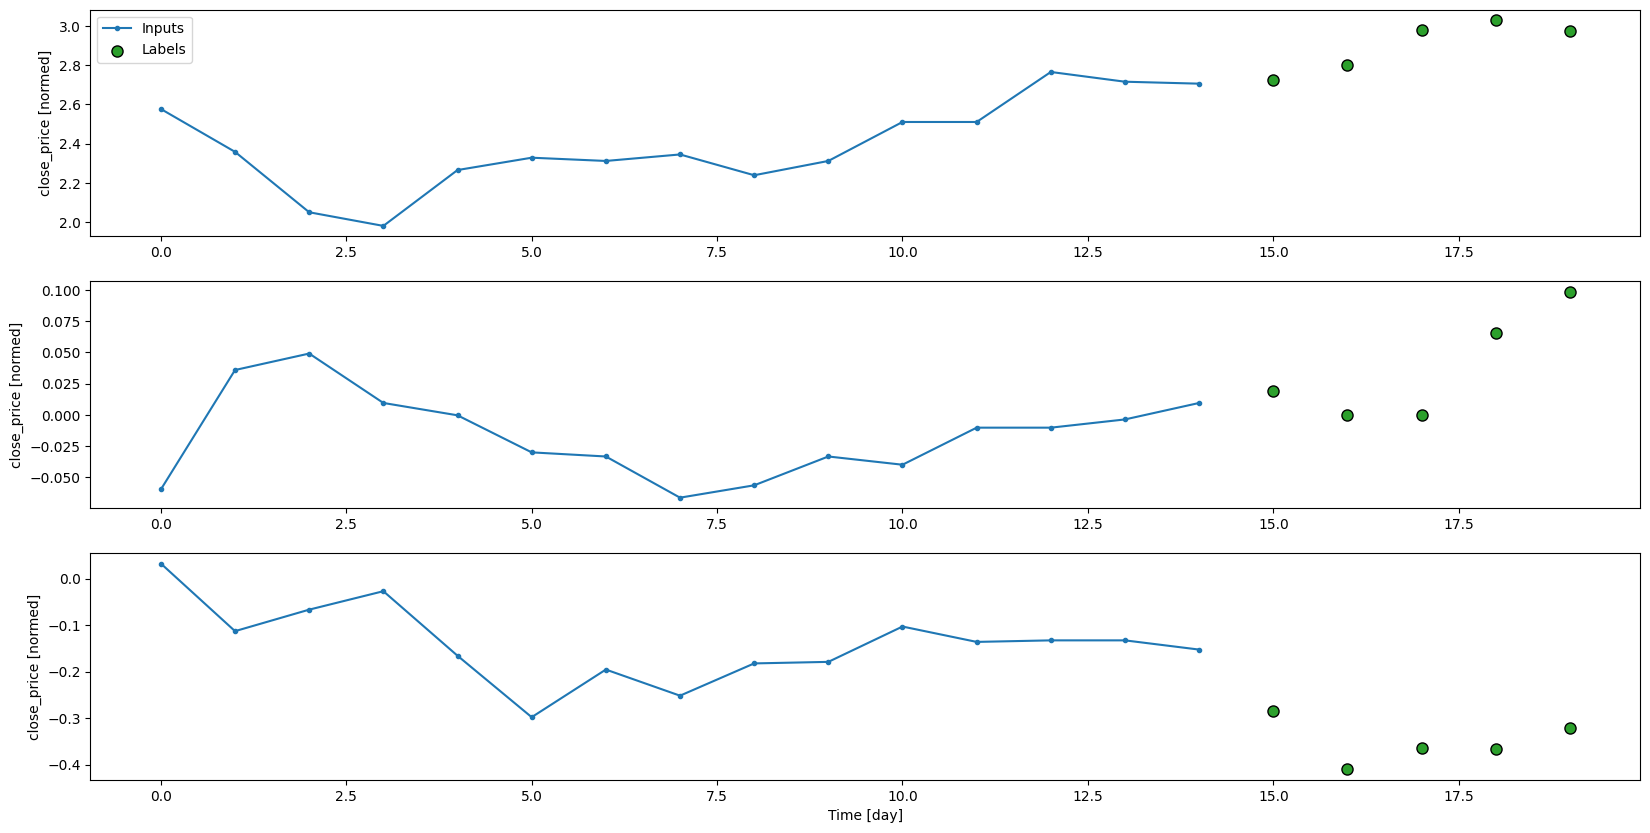

In [39]:
multi_window.plot()

Create dataset

In [40]:
def make_dataset(self, data): #data lấy liên tục 
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,#to avoid sequence bias
      batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [41]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [42]:
for inputs, labels in multi_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

Inputs shape (batch, time, features): (32, 15, 26)
Labels shape (batch, time, features): (32, 5, 1)


In [43]:
multi_window.train

<_MapDataset element_spec=(TensorSpec(shape=(None, 15, 26), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))>

Build and Train model

In [44]:
tf.keras.backend.clear_session()
MAX_EPOCHS = 100

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def compile_and_fit(model, window, patience=20):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')
    # Set the learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

        
    model.compile(#loss=tf.keras.losses.MeanSquaredError()
                  loss=tf.keras.losses.Huber(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError(),
                         tf.keras.metrics.RootMeanSquaredError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping,lr_schedule],verbose=1)
    return history

In [45]:
def plot_train (history):
    # list all data in history
    print(history.history.keys())

    # summarize history for loss

    fig, ax = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

Simple CNN

In [46]:
CONV_WIDTH =3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

1/1 [==============================] - 0s 31ms/step - loss: 0.0272 - mean_absolute_error: 0.1936 - root_mean_squared_error: 0.2333
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


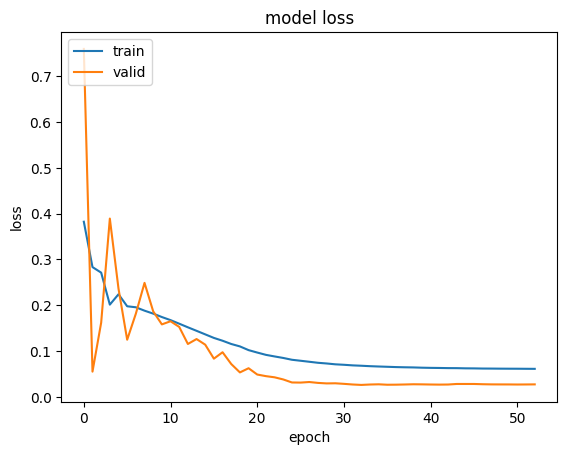

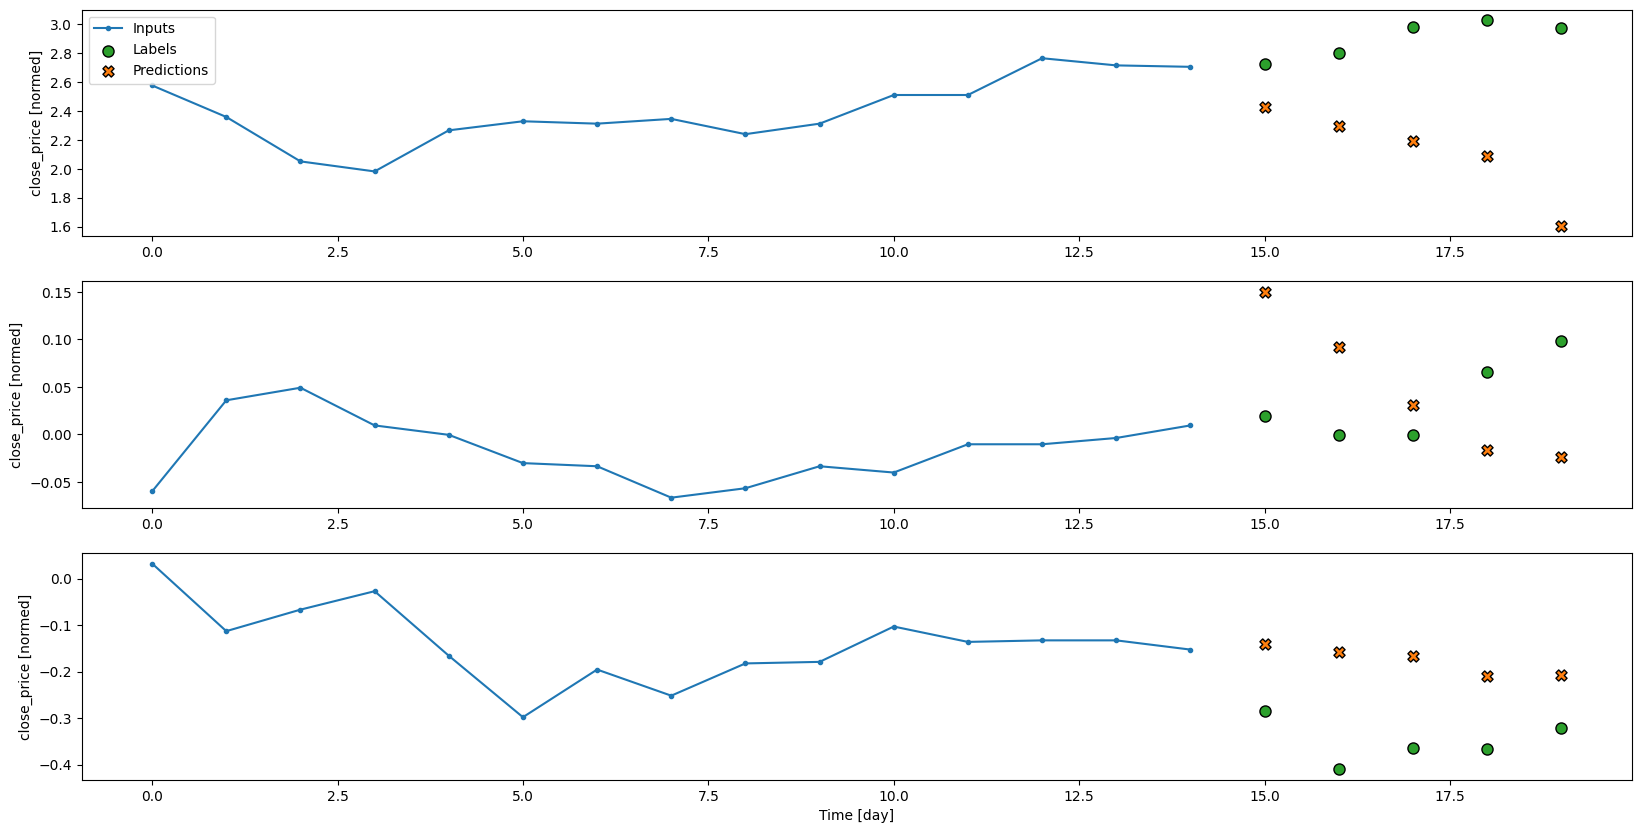

In [47]:
multi_conv_history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance = {}
multi_performance = {}

IPython.display.clear_output()

multi_val_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Simple Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
plot_train(multi_conv_history)
multi_window.plot(multi_conv_model)

In [48]:
multi_conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 3, 26)             0         
                                                                 
 conv1d (Conv1D)             (None, 1, 256)            20224     
                                                                 
 dense (Dense)               (None, 1, 130)            33410     
                                                                 
 reshape (Reshape)           (None, 5, 26)             0         
                                                                 
Total params: 53,634
Trainable params: 53,634
Non-trainable params: 0
_________________________________________________________________


Multi LSTM

1/1 [==============================] - 0s 138ms/step - loss: 0.1093 - mean_absolute_error: 0.3860 - root_mean_squared_error: 0.4676
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


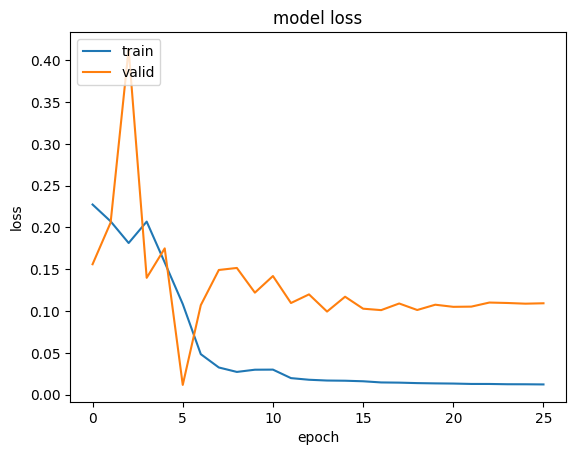

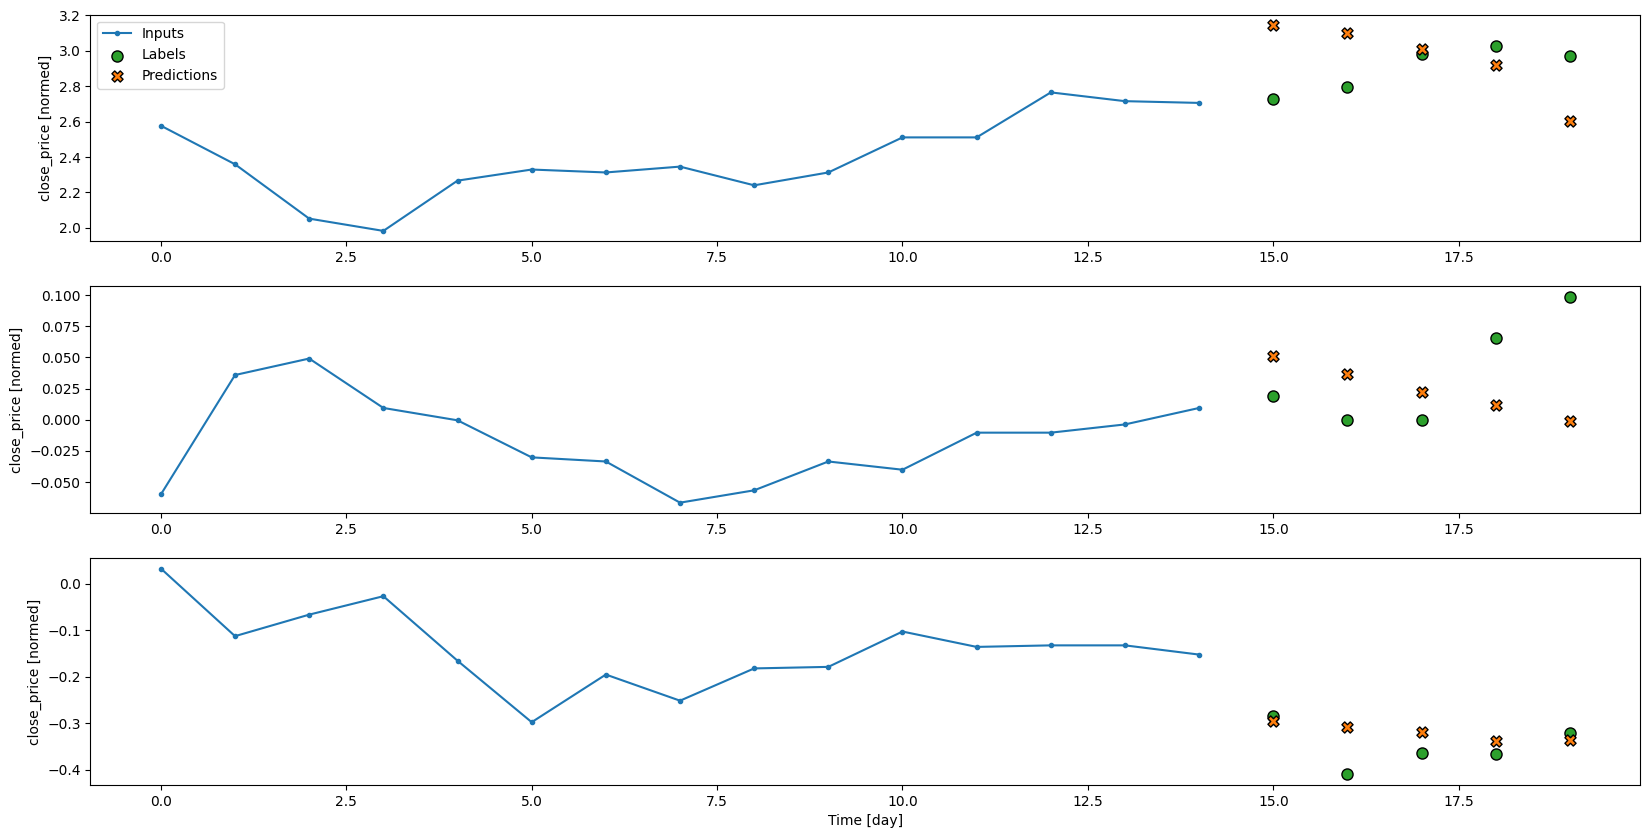

In [49]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(1024, return_sequences=True),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.LSTM(1024, return_sequences=False),
    
    tf.keras.layers.Dense(512, activation = 'relu'), 
    
    tf.keras.layers.Dense(256),
    
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history_multi_lstm = compile_and_fit(multi_lstm_model, multi_window)
IPython.display.clear_output()
multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
plot_train(history_multi_lstm)
multi_window.plot(multi_lstm_model)

In [50]:
multi_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 1024)          4304896   
                                                                 
 lstm_1 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 130)               33410     
                                                                 
 reshape_1 (Reshape)         (None, 5, 26)             0         
                                                                 
Total params: 13,387,138
Trainable params: 13,387,138


Complex CNN

In [51]:
CONV_WIDTH = 3

def build_CNN_model(input_shape = (input_width,num_features)): #input_shape (time steps,features)
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)

    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    #x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x) 
    
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(512)(x)
                              
    x = tf.keras.layers.Dense(OUT_STEPS*num_features) (x)
    # Shape => [batch, out_steps, features]
    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_model = build_CNN_model()
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 26, 1)]       0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 24, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 22, 128)      24704     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 20, 256)      98560     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 18, 128)      98432     
 tributed)                                                   

1/1 [==============================] - 0s 55ms/step - loss: 0.0696 - mean_absolute_error: 0.3461 - root_mean_squared_error: 0.3730
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


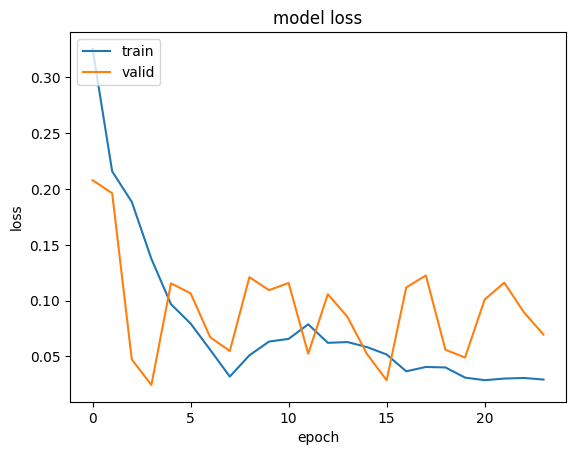

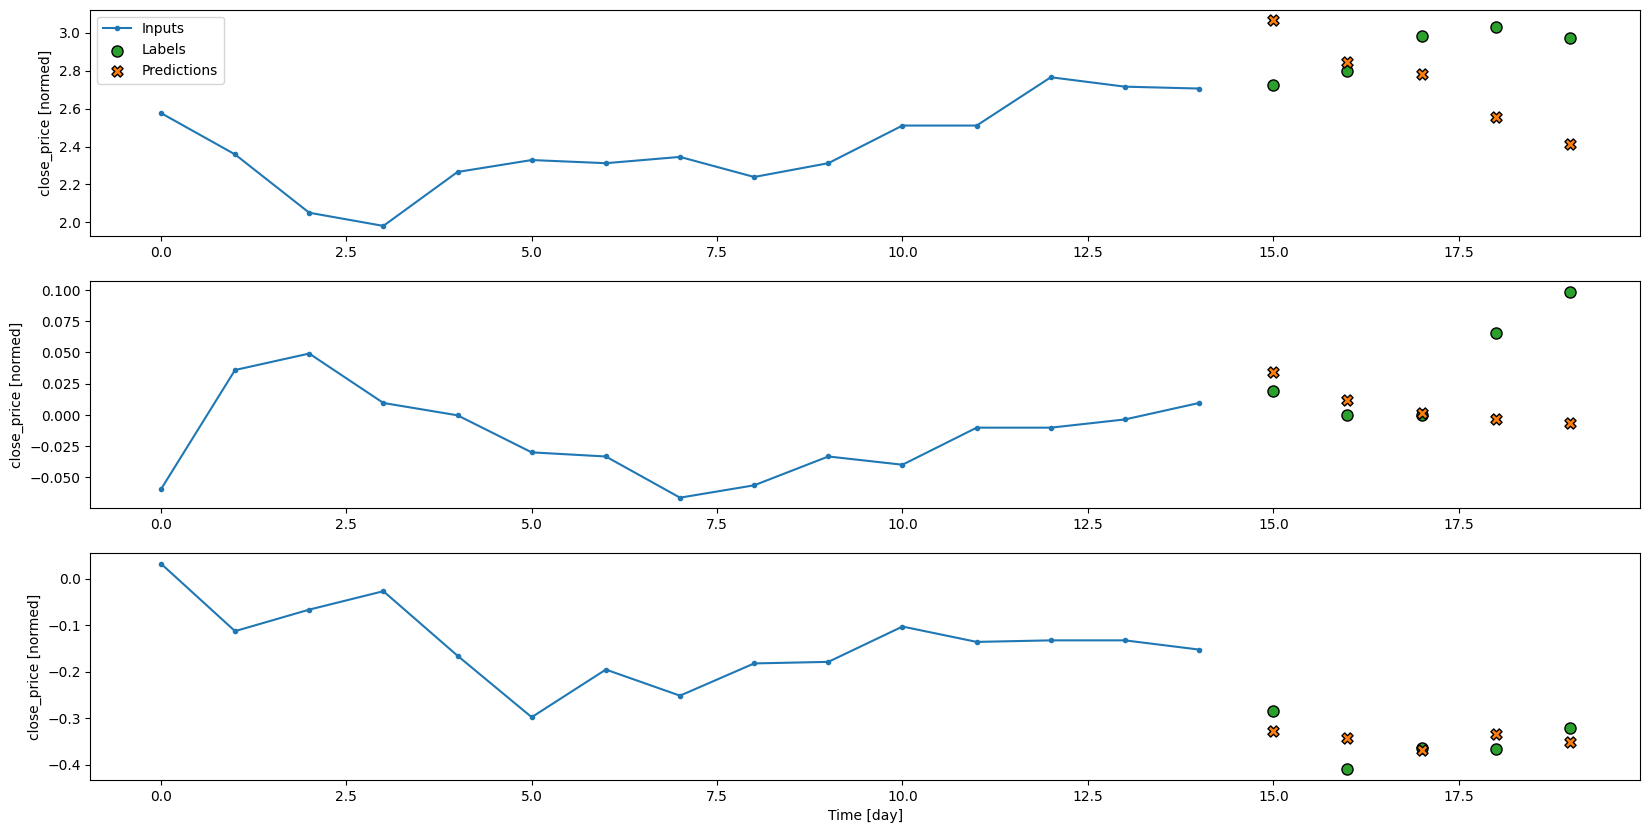

In [52]:
tf.keras.backend.clear_session()
history_CNN = compile_and_fit(CNN_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN'] = CNN_model.evaluate(multi_window.val)
multi_performance['CNN'] = CNN_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN)
multi_window.plot(CNN_model)

CNN + LSTM

In [53]:
CONV_WIDTH = 3

def build_CNN_LSTM_model(input_shape = (input_width,num_features)):
    
    input = tf.keras.Input(shape=(input_shape[0],input_shape[1],1))
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(64, activation='relu', kernel_size=(CONV_WIDTH)))(input)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(128, activation='relu', kernel_size=(CONV_WIDTH)))(x)

    x = tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPool1D(pool_size=2))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(x)
    
    # x = tf.keras.layers.TimeDistributed(tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten())(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(x)
    
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=False, dropout=0.5))(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

CNN_LSTM_model = build_CNN_LSTM_model()
CNN_LSTM_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 26, 1)]       0         
                                                                 
 time_distributed (TimeDistr  (None, 15, 24, 64)       256       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 12, 64)       0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 15, 10, 128)      24704     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 15, 5, 128)       0         
 tributed)                                                   

1/1 [==============================] - 0s 43ms/step - loss: 0.0319 - mean_absolute_error: 0.2247 - root_mean_squared_error: 0.2527
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


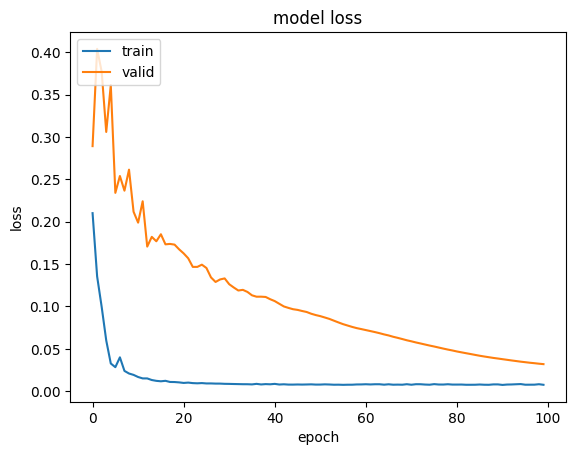

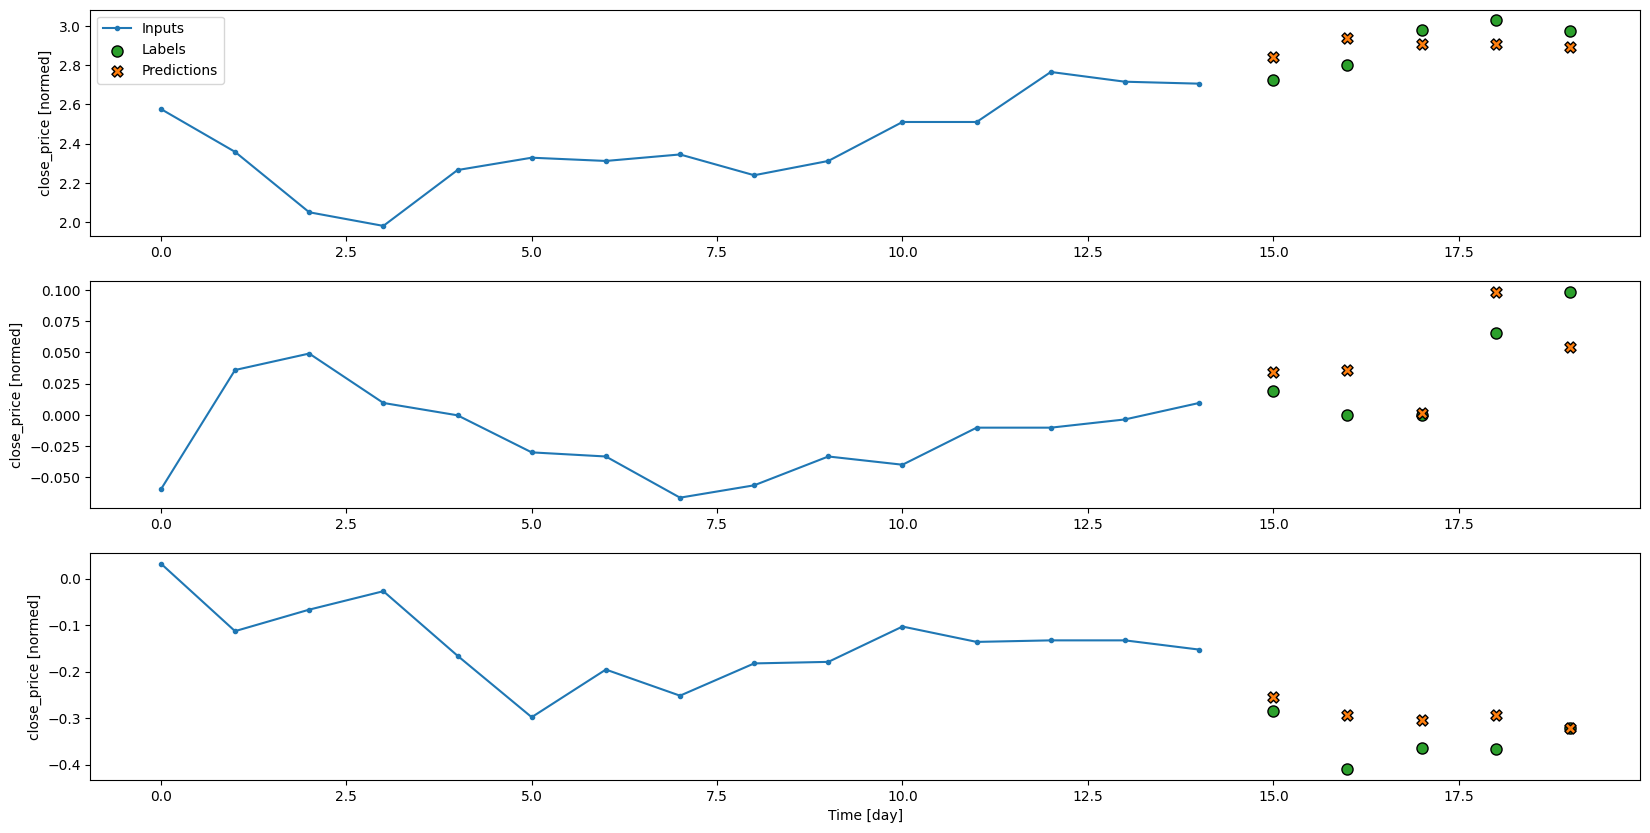

In [54]:
history_CNN_LSTM = compile_and_fit(CNN_LSTM_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.val)
multi_performance['CNN_LSTM'] = CNN_LSTM_model.evaluate(multi_window.test, verbose=0)
plot_train(history_CNN_LSTM)
multi_window.plot(CNN_LSTM_model)

LSTM + Dense

In [55]:
def build_LSTM_Dense_model():
    
    input = tf.keras.Input(shape= (input_width,num_features))
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True))(input)
    
    x = tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, dropout=0.5))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu'))(x)
    
    x = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu'))(x)
    
    x = tf.keras.layers.Flatten()(x)
    
    x = tf.keras.layers.Dense(OUT_STEPS*num_features)(x)

    output = tf.keras.layers.Reshape([OUT_STEPS, num_features])(x)

    model = tf.keras.Model(inputs=input, outputs=output)
    
    return model

LSTM_Dense_model = build_LSTM_Dense_model()
LSTM_Dense_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15, 26)]          0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 15, 512)          579584    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 15, 512)          1574912   
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 15, 256)          131328    
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 15, 128)          32896     
 tributed)                                                 

1/1 [==============================] - 0s 53ms/step - loss: 0.0554 - mean_absolute_error: 0.2667 - root_mean_squared_error: 0.3329
dict_keys(['loss', 'mean_absolute_error', 'root_mean_squared_error', 'val_loss', 'val_mean_absolute_error', 'val_root_mean_squared_error', 'lr'])


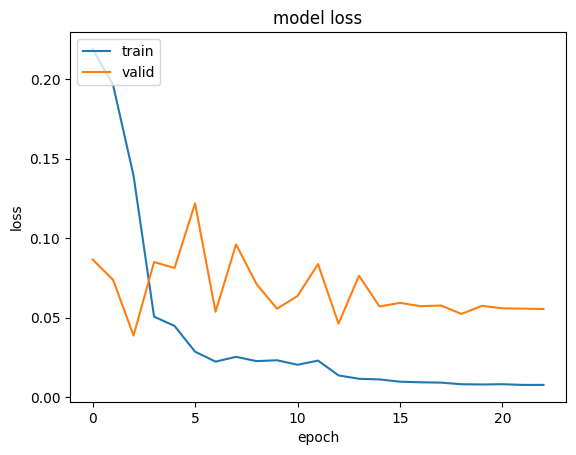

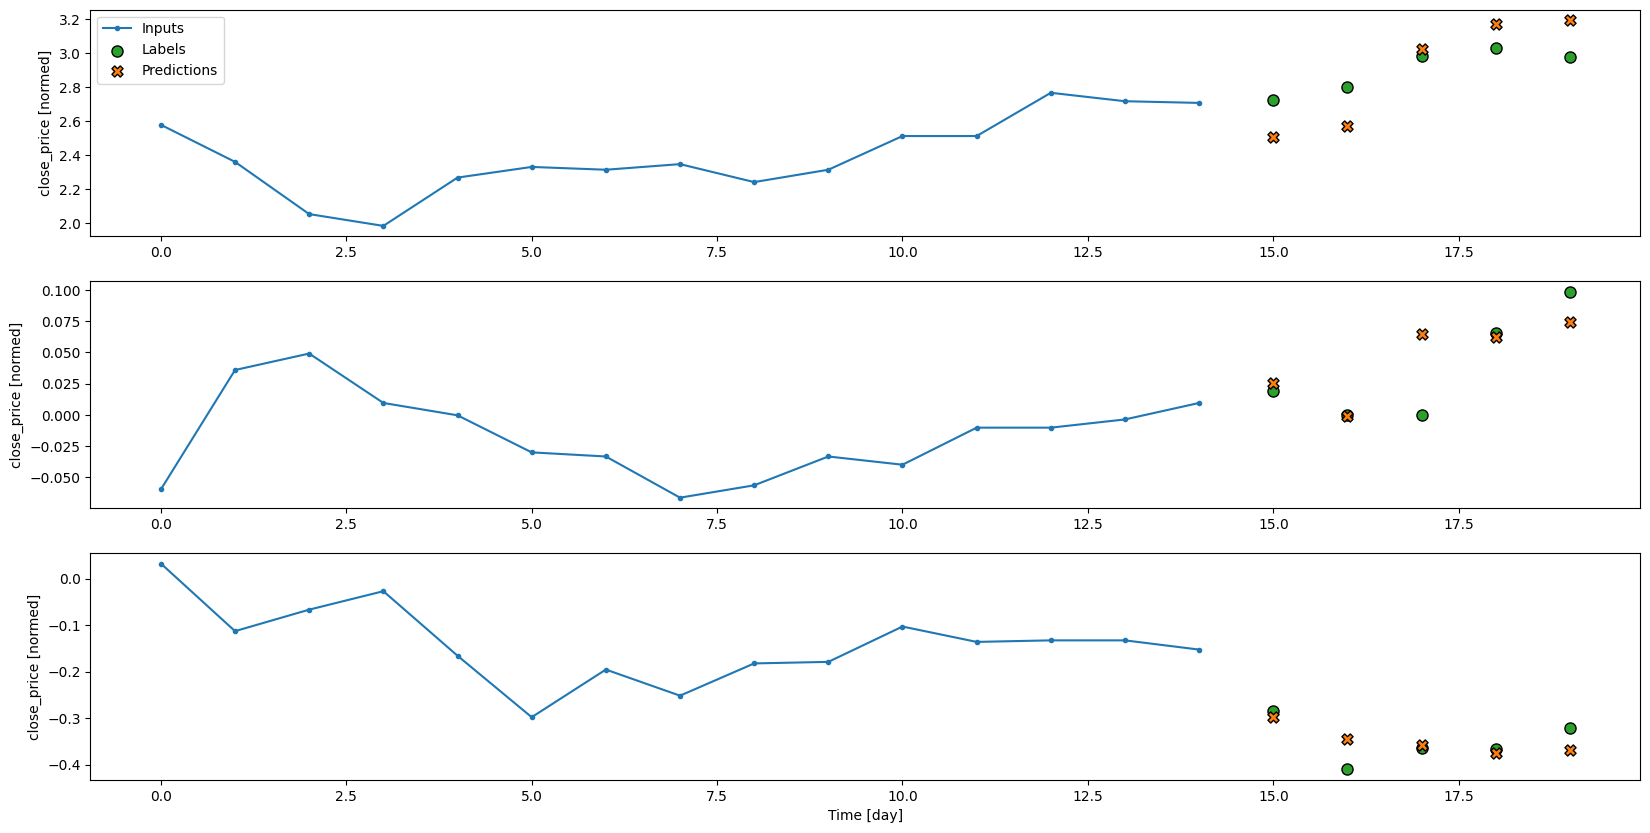

In [56]:
history_LSTM_Dense = compile_and_fit(LSTM_Dense_model, multi_window)

#multi_val_performance = {}
#multi_performance = {}
IPython.display.clear_output()
multi_val_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.val)
multi_performance['LSTM_Dense'] = LSTM_Dense_model.evaluate(multi_window.test, verbose=0)
plot_train(history_LSTM_Dense)
multi_window.plot(LSTM_Dense_model)

# RESULT 

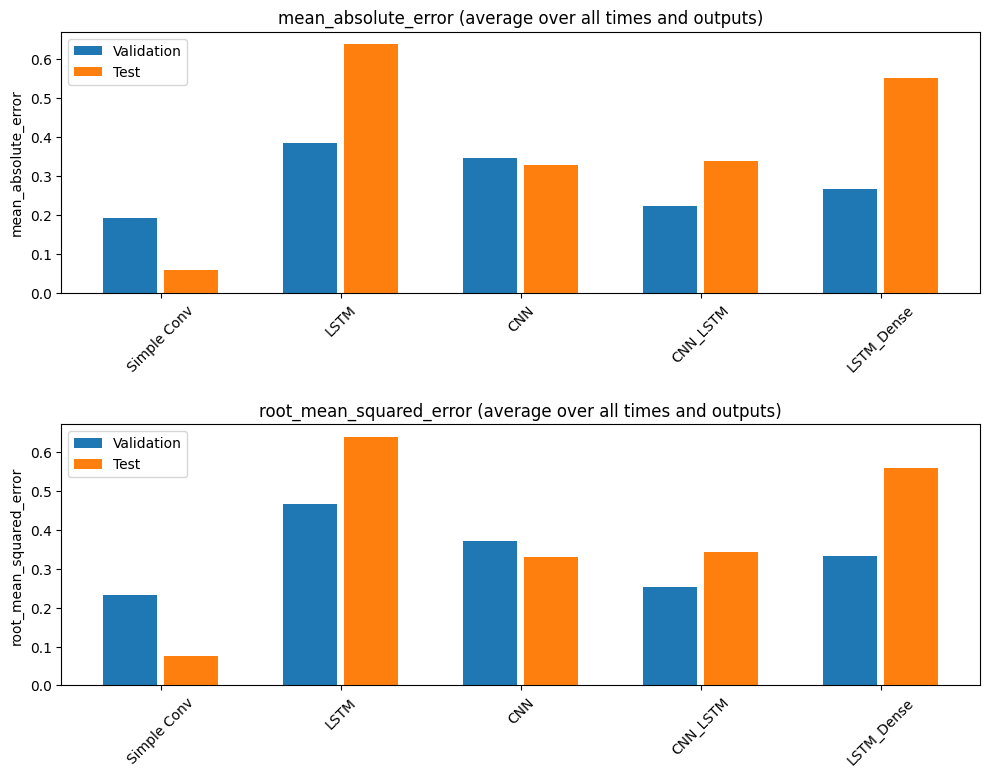

In [57]:
x = np.arange(len(multi_performance))
width = 0.3

plt.figure(figsize=(10, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)

metric_name = LSTM_Dense_model.metrics_names[1:] #we don't draw loss
for i, name in enumerate(metric_name,1):
    plt.subplot(2, 1, i)
    
    metric_index = LSTM_Dense_model.metrics_names.index(name)
    val_mae = [v[metric_index] for v in multi_val_performance.values()]
    test_mae = [v[metric_index] for v in multi_performance.values()]

    plt.bar(x - 0.17, val_mae, width, label='Validation')
    plt.bar(x + 0.17, test_mae, width, label='Test')
    plt.title (f'{name} (average over all times and outputs)')
    plt.xticks(ticks=x, labels=multi_performance.keys(),
               rotation=45)
    plt.ylabel(f'{name}') #(average over all times and outputs)
    _ = plt.legend()
    
plt.tight_layout()

# INFERENCE

In [58]:
test_window = tf.stack([np.array(test_df[test_df.shape[0] - input_width: test_df.shape[0]])])


In [59]:
scaler = Numerical.named_steps['standard scaler']

Denormalize prediction

In [60]:
def denorm(inputs,scaler, num_cols = num_cols):
    denorm_array = []
    for input in inputs:
        denorm_input = scaler.inverse_transform(input[:,:len(num_cols)])
        denorm_array.append(denorm_input)
    denorm_array = np.array(denorm_array,dtype=float)    
    return denorm_array

In [61]:
def plot_inference_denorm(self, model=None, plot_col='close_price', max_subplots=1, inputs = test_window, model_name = "model"):
    
    
    denorm_inputs = denorm(inputs, scaler)
    # print (denorm_input[:, plot_col_index])
    plt.figure(figsize=(20, 7))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [denormed]')
        plt.plot(self.input_indices, denorm_inputs[n,:, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if model is not None:
            predictions = model(inputs)
            denormalized_predictions = denorm(predictions,scaler)

            plt.scatter(self.label_indices, denormalized_predictions[n, :, plot_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
            print (denormalized_predictions[n, :, plot_col_index])
            plt.title(model_name)
        if n == 0:
            plt.legend(loc='upper left')

    plt.xlabel('Time [day]')
    

WindowGenerator.plot_inference_denorm = plot_inference_denorm

All models

In [62]:
models = [multi_conv_model, multi_lstm_model, CNN_model,LSTM_Dense_model,CNN_LSTM_model]

dict_keys(['Simple Conv', 'LSTM', 'CNN', 'CNN_LSTM', 'LSTM_Dense'])
Simple Conv
[36.72236482 37.18511768 37.77502321 38.43555388 40.81488811]
LSTM
[55.18277329 54.78934568 54.39438363 53.83275721 53.78029983]
CNN
[49.4814561  49.74250804 49.55411361 50.24396617 48.74688505]
CNN_LSTM
[46.55944169 47.88704666 46.18150177 44.50488277 47.26534124]
LSTM_Dense
[49.95504106 52.07585818 51.23278302 50.24740307 51.52493665]


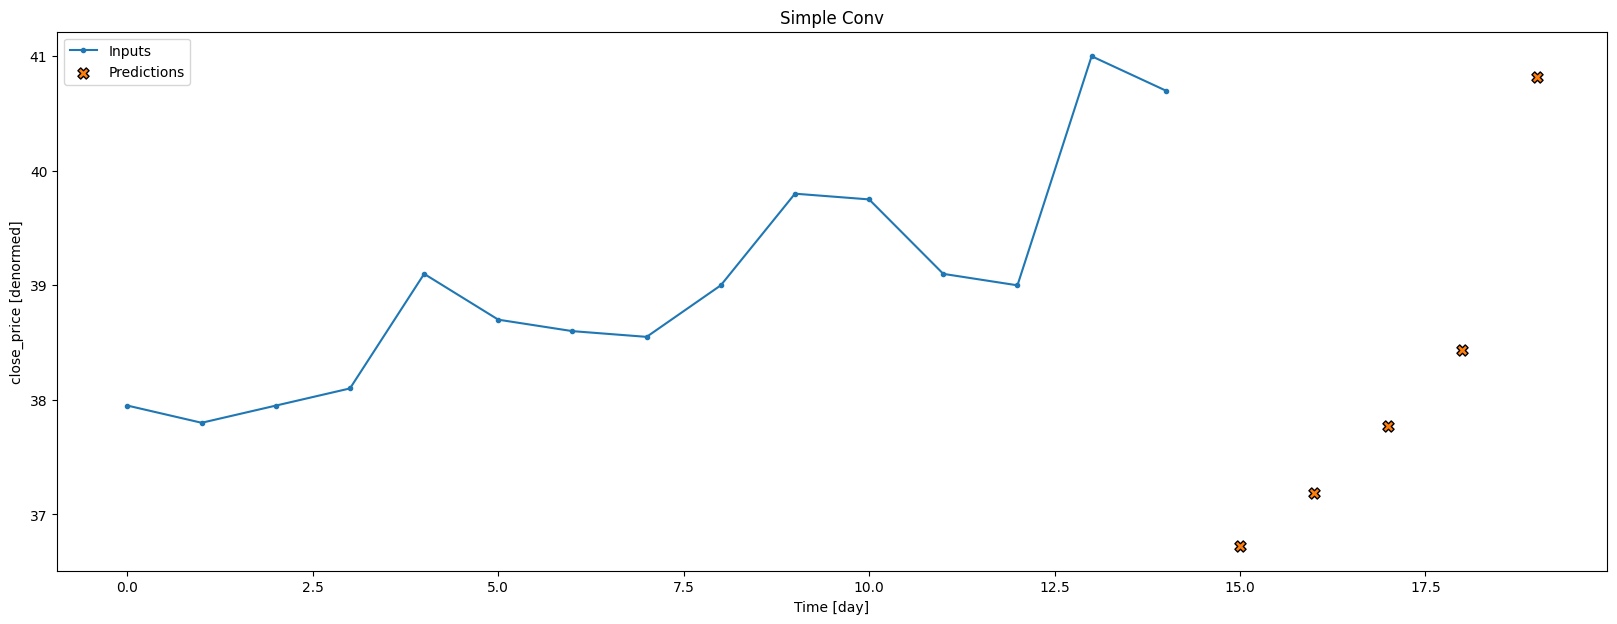

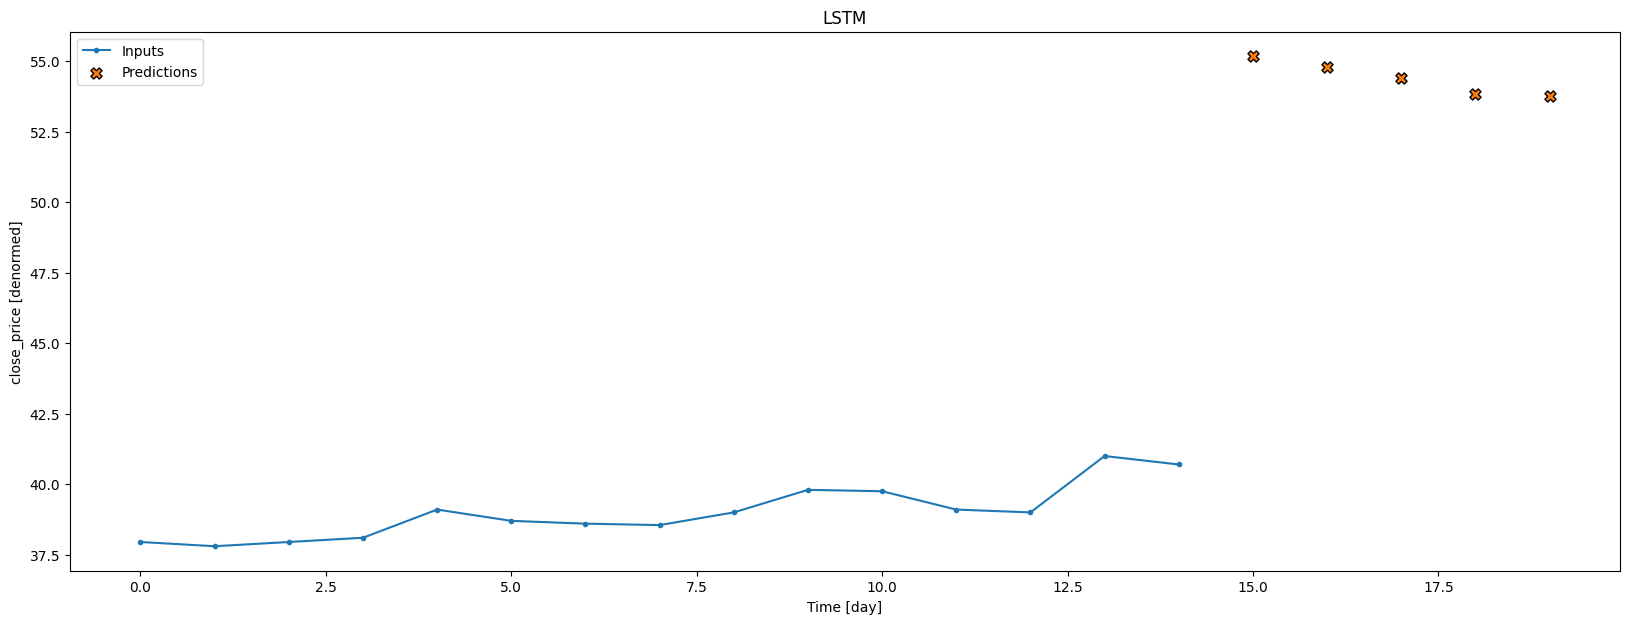

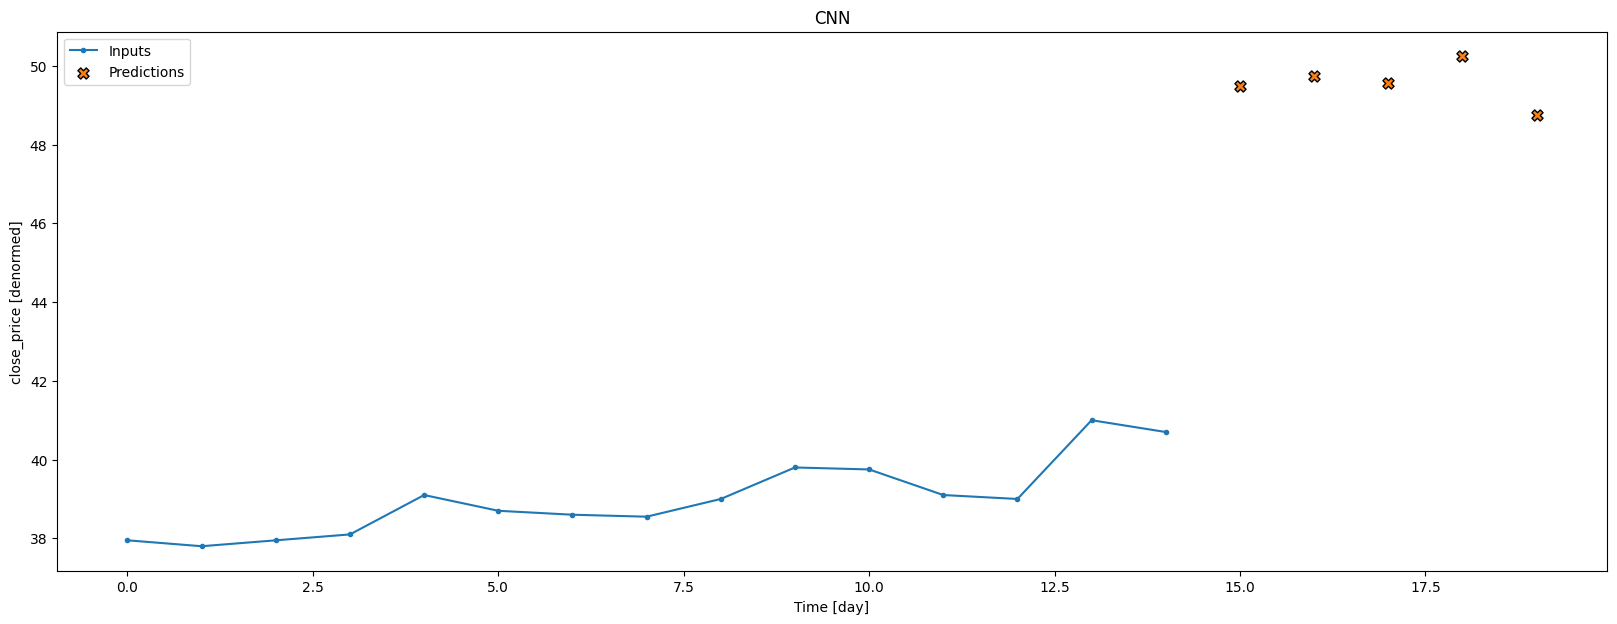

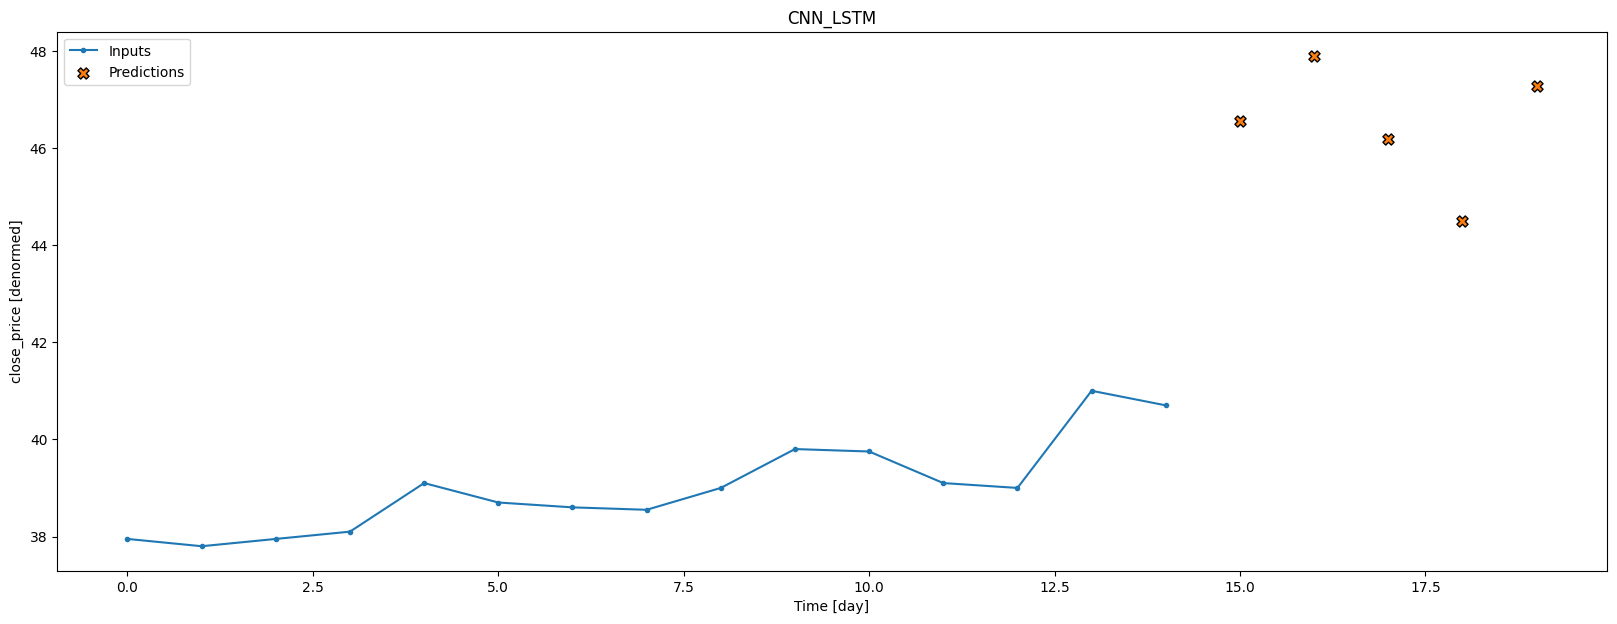

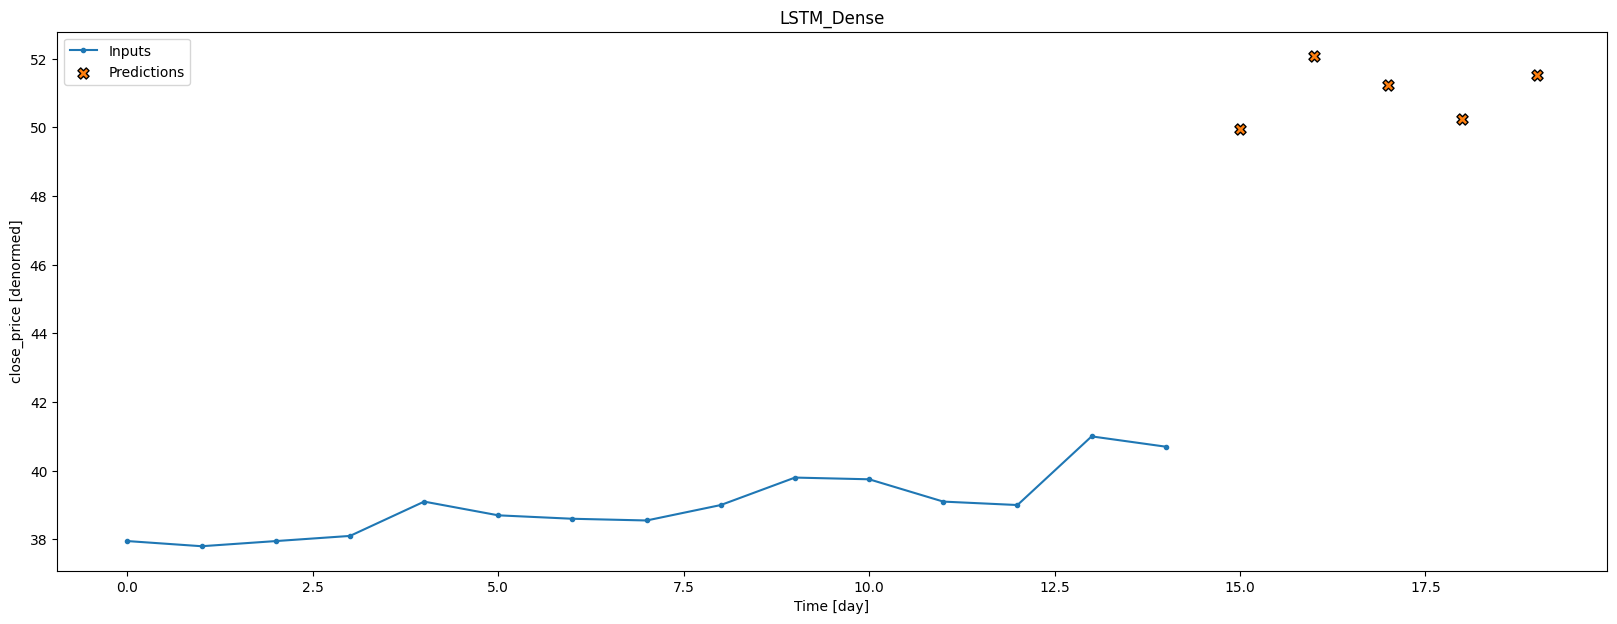

In [63]:
print(multi_performance.keys())
for model_name, model in zip(multi_performance.keys(), models):
    print (model_name)
    multi_window.plot_inference_denorm(model, model_name = model_name)